In [1]:
library(dplyr)
library(lubridate)
library(leaflet)
library(sf)
library(sp)
library(geojsonio)
library(rgdal)
library(forecast)
library(ggplot2)
library(riskyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3
Registered S3 method overwritten by 'geojsonio':
  method         from 
  print.location dplyr

Attaching package: 'geojsonio'

The following object is masked from 'package:base':

    pretty

rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: C:/Users/Serena/Anaconda3/envs/Renv/Lib/R/library/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/Serena/Anaconda3/envs/Renv/Lib/R/library/rgdal/proj
 Linking to 

In [2]:
# test accuracy of predictions
plotForecastErrors <- function(forecasterrors)
  {
     # make a histogram of the forecast errors:
     mybinsize <- IQR(forecasterrors, na.rm=TRUE)/4
     mysd   <- sd(forecasterrors, na.rm=TRUE)
     mymin  <- min(forecasterrors, na.rm=TRUE) - mysd*5
     mymax  <- max(forecasterrors, na.rm=TRUE) + mysd*3
     # generate normally distributed data with mean 0 and standard deviation mysd
     mynorm <- rnorm(10000, mean=0, sd=mysd)
     mymin2 <- min(mynorm)
     mymax2 <- max(mynorm)
     if (mymin2 < mymin) { mymin <- mymin2 }
     if (mymax2 > mymax) { mymax <- mymax2 }
     # make a red histogram of the forecast errors, with the normally distributed data overlaid:
     mybins <- seq(mymin, mymax, mybinsize)
     hist(forecasterrors, col="red", freq=FALSE, breaks=mybins)
     # freq=FALSE ensures the area under the histogram = 1
     # generate normally distributed data with mean 0 and standard deviation mysd
     myhist <- hist(mynorm, plot=FALSE, breaks=mybins)
     # plot the normal curve as a blue line on top of the histogram of forecast errors:
     points(myhist$mids, myhist$density, type="l", col="blue", lwd=2)
  }

## Create Spatial Points Dataframe for NYC Boroughs

#### For this exercise, locations have been interpreted as Boroughs
    - load borough boundaries file
    - Review column names, and proj4 values
    - Verify Polygon df is created

Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x -74.25559 -73.70001
y  40.49612  40.91553
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0]
Data attributes:
 boro_code         boro_name         shape_area         shape_leng
 1:1       Bronx        :1   1186612476.77:1    325960.634597:1   
 2:1       Brooklyn     :1   1623756421.84:1    361212.479734:1   
 3:1       Manhattan    :1   1937593021.46:1    462958.188213:1   
 4:1       Queens       :1   3045885240.47:1    738745.835869:1   
 5:1       Staten Island:1   636602662.347:1    904390.137335:1   

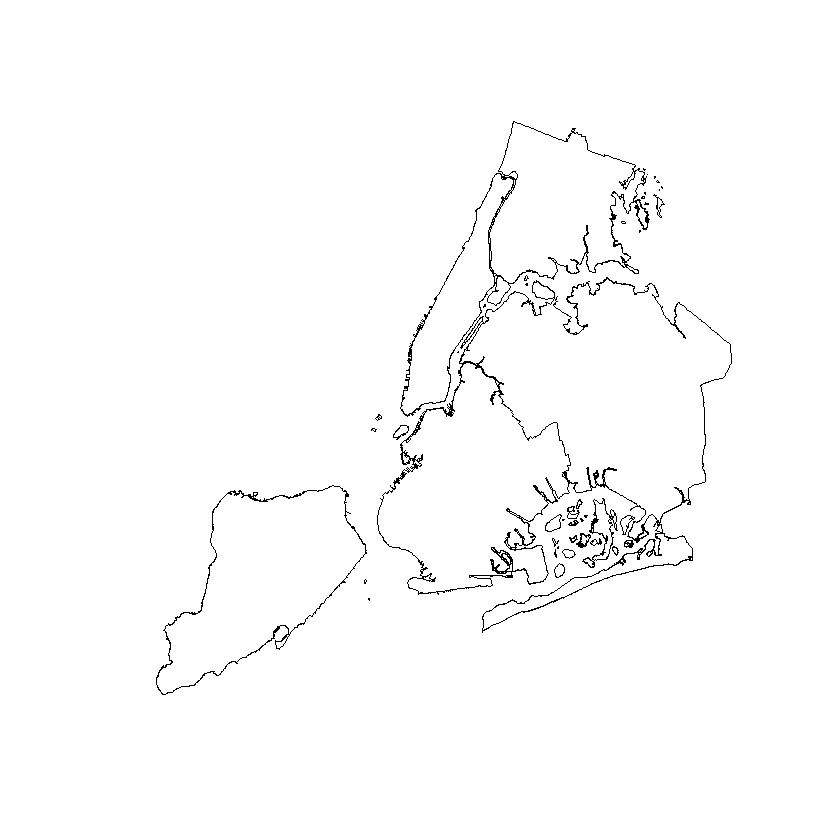

In [3]:
boroLocs <- geojson_read("Borough Boundaries.geojson", what = "sp")
summary(boroLocs)
plot(boroLocs)

### Load ride share data
    join it to borough polygons

In [4]:
RideShareApr14 <- read.csv("uber-raw-data-apr14.csv", header=TRUE, sep=",")
RideShareMay14 <- read.csv("uber-raw-data-may14.csv", header=TRUE, sep=",")
RideShareJun14 <- read.csv("uber-raw-data-jun14.csv", header=TRUE, sep=",")
RideShareJul14 <- read.csv("uber-raw-data-jul14.csv", header=TRUE, sep=",")
RideShareAug14 <- read.csv("uber-raw-data-aug14.csv", header=TRUE, sep=",")
RideShareSep14 <- read.csv("uber-raw-data-sep14.csv", header=TRUE, sep=",")

RideShare <- rbind(RideShareApr14,RideShareMay14,RideShareJun14,RideShareJul14,RideShareAug14,RideShareSep14)

# Coerce into SpatialPointDataFrame
rs_spdf <- RideShare
coordinates(rs_spdf) <- ~Lon + Lat

# Assign projection
proj4string(rs_spdf) <- proj4string(boroLocs)
summary(rs_spdf)

Object of class SpatialPointsDataFrame
Coordinates:
         min      max
Lon -74.9290 -72.0666
Lat  39.6569  42.1166
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0]
Number of points: 4534327
Data attributes:
              Date.Time           Base        
 4/7/2014 20:21:00 :     97   B02512: 205673  
 6/13/2014 18:03:00:     88   B02598:1393113  
 4/7/2014 20:22:00 :     87   B02617:1458853  
 9/13/2014 18:44:00:     82   B02682:1212789  
 9/13/2014 18:41:00:     80   B02764: 263899  
 7/15/2014 19:30:00:     79                   
 (Other)           :4533814                   

In [5]:
# Find the borough of each pick-up
matches <- over(rs_spdf, boroLocs)
head(matches)
summary(matches)

boro_code,boro_name,shape_area,shape_leng
1,Manhattan,636602662.347,361212.479734
NA,NA,NA,NA
1,Manhattan,636602662.347,361212.479734
1,Manhattan,636602662.347,361212.479734
1,Manhattan,636602662.347,361212.479734
NA,NA,NA,NA


 boro_code              boro_name               shape_area     
 1   :3443458   Bronx        :  31584   1186612476.77:  31584  
 2   :  31584   Brooklyn     : 593594   1623756421.84:   1034  
 3   : 593594   Manhattan    :3443458   1937593021.46: 593594  
 4   : 342225   Queens       : 342225   3045885240.47: 342225  
 5   :   1034   Staten Island:   1034   636602662.347:3443458  
 NA's: 122432   NA's         : 122432   NA's         : 122432  
         shape_leng     
 325960.634597:   1034  
 361212.479734:3443458  
 462958.188213:  31584  
 738745.835869: 593594  
 904390.137335: 342225  
 NA's         : 122432  

In [6]:
RideShare <- cbind(RideShare, matches)
head(RideShare)

Date.Time,Lat,Lon,Base,boro_code,boro_name,shape_area,shape_leng
4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,Manhattan,636602662.347,361212.479734
4/1/2014 0:17:00,40.7267,-74.0345,B02512,NA,NA,NA,NA
4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,Manhattan,636602662.347,361212.479734
4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,Manhattan,636602662.347,361212.479734
4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,Manhattan,636602662.347,361212.479734
4/1/2014 0:33:00,40.7383,-74.0403,B02512,NA,NA,NA,NA


In [7]:
# Rename data/time column, and set format
colnames(RideShare)[colnames(RideShare)=="Date.Time"] <- "Date"
RideShare$Date <- as.Date(RideShare$Date, format="%m/%d/%Y %H:%M:%S")

summary(RideShare)

      Date                 Lat             Lon             Base        
 Min.   :2014-04-01   Min.   :39.66   Min.   :-74.93   B02512: 205673  
 1st Qu.:2014-05-28   1st Qu.:40.72   1st Qu.:-74.00   B02598:1393113  
 Median :2014-07-17   Median :40.74   Median :-73.98   B02617:1458853  
 Mean   :2014-07-11   Mean   :40.74   Mean   :-73.97   B02682:1212789  
 3rd Qu.:2014-08-27   3rd Qu.:40.76   3rd Qu.:-73.97   B02764: 263899  
 Max.   :2014-09-30   Max.   :42.12   Max.   :-72.07                   
 boro_code              boro_name               shape_area     
 1   :3443458   Bronx        :  31584   1186612476.77:  31584  
 2   :  31584   Brooklyn     : 593594   1623756421.84:   1034  
 3   : 593594   Manhattan    :3443458   1937593021.46: 593594  
 4   : 342225   Queens       : 342225   3045885240.47: 342225  
 5   :   1034   Staten Island:   1034   636602662.347:3443458  
 NA's: 122432   NA's         : 122432   NA's         : 122432  
         shape_leng     
 325960.634597:   1034 

In [8]:
# Remove locations (NA values) outside area of interest
BoroSummary <- RideShare %>% group_by(Date, boro_name) %>% summarize(Rides=n()) %>% filter(boro_name!='NA')
head(BoroSummary)

Warning message:
"Factor `boro_name` contains implicit NA, consider using `forcats::fct_explicit_na`"

Date,boro_name,Rides
2014-04-01,Bronx,64
2014-04-01,Brooklyn,1481
2014-04-01,Manhattan,11730
2014-04-01,Queens,860
2014-04-01,Staten Island,4
2014-04-02,Bronx,77


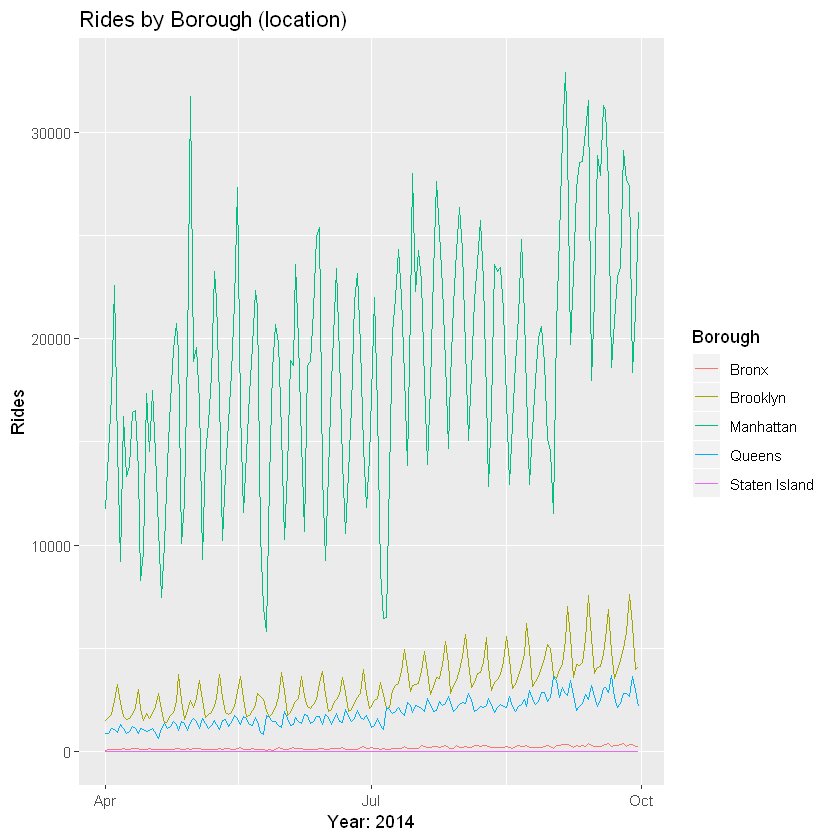

In [9]:
# create graphical representation of pick-ups per borough
ggplot(data = BoroSummary, aes(x = Date, y = Rides, colour=boro_name)) + 
geom_line() +
ggtitle("Rides by Borough (location)") +
ylab("Rides") + xlab("Year: 2014") +
labs(colour="Borough")

In [10]:
# Create a continuous palette function
pal <- colorNumeric(
  palette = "GnBu",
  domain = log10(BoroSummary$Rides))

# Show pick-up location ridership heat-map
leaflet(boroLocs) %>%
  addTiles() %>% 
  addPolygons(stroke = FALSE, smoothFactor = 0.3, fillOpacity = 1,
    fillColor = ~pal(log10(BoroSummary$Rides)),
    label = ~paste0(BoroSummary$boro_name, ": ", formatC(BoroSummary$Rides, big.mark = ","))) %>%
  addLegend(pal = pal, values = ~log10(BoroSummary$Rides), opacity = 1.0,
    labFormat = labelFormat(transform = function(x) round(10^x)), title = NULL) %>%
  addProviderTiles("CartoDB.Positron")

HTML widgets cannot be represented in plain text (need html)

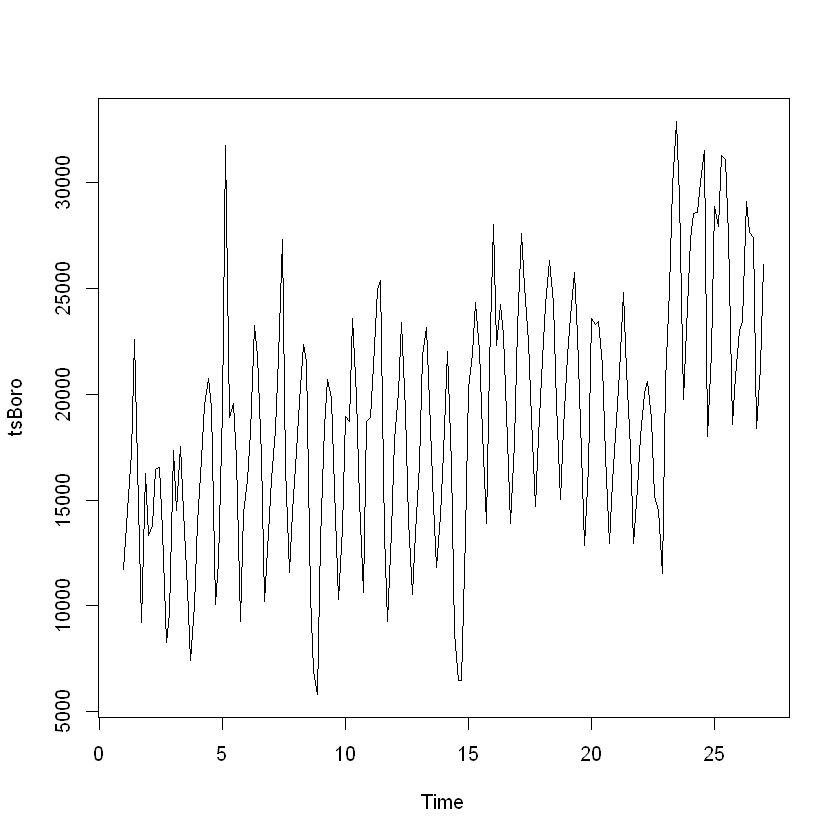

In [11]:
# create time series for Manhattan rides for Apr - Sept 2014
BoroSummary <- filter(BoroSummary,boro_name=="Manhattan")

tsBoro <- ts(BoroSummary$Rides,frequency=7) #weekly frequency
plot(tsBoro)

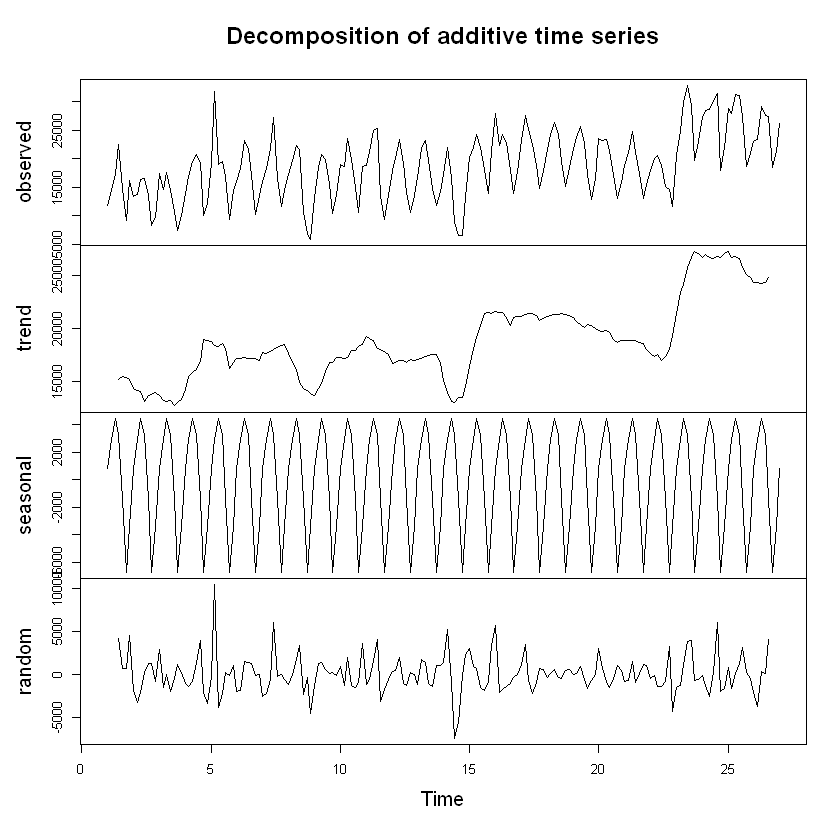

In [12]:
# decompose in order to evaluate seasonal component of series
BoroRideComponents <- decompose(tsBoro)
plot(BoroRideComponents)

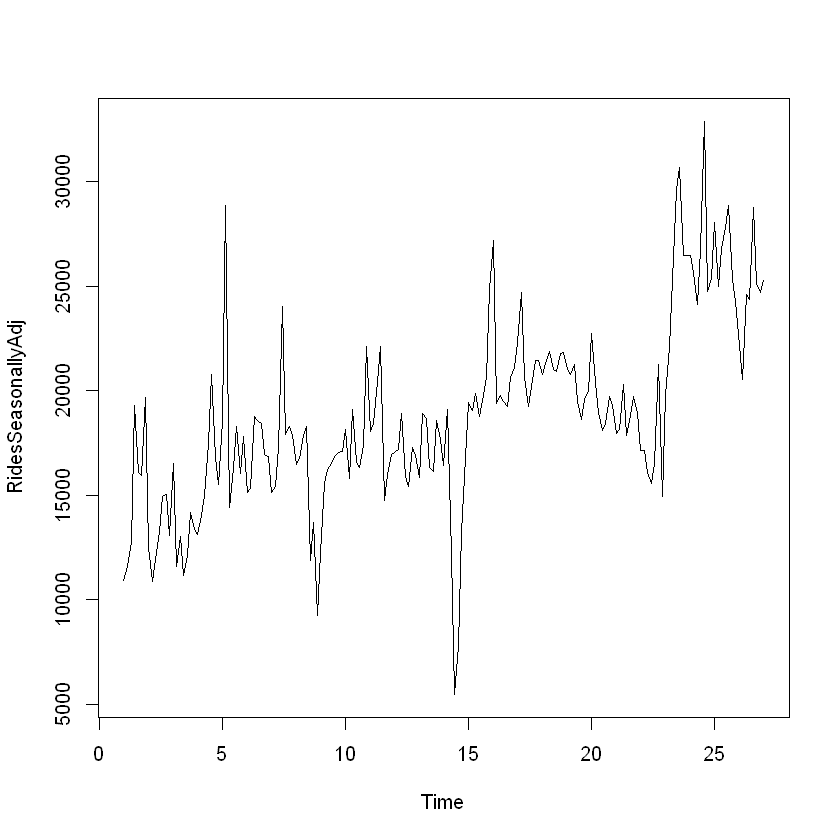

In [24]:
RidesSeasonallyAdj <- tsBoro - BoroRideComponents$seasonal
plot(RidesSeasonallyAdj)

In [25]:
# As evidenced by above seasonally adjusted plot, Manhattan's time series proves to be roughly additive, 
# try Holt-Winters exponential smoothing to complete the short-term forecast
hwBoro <- HoltWinters(tsBoro)
hwBoro
# alpha relatively low - both recent and past observations considered
# beta shows increase in growth over time
# seasonal component based on both recent and past observations
hwBoro$SSE

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = tsBoro)

Smoothing parameters:
 alpha: 0.4298121
 beta : 0.01471693
 gamma: 0.4050367

Coefficients:
          [,1]
a  24091.51822
b     48.09006
s1  3575.82578
s2  7000.14747
s3  6027.89429
s4  3103.66914
s5 -5746.61209
s6 -2967.67475
s7  1995.50053

[1] 1650835896

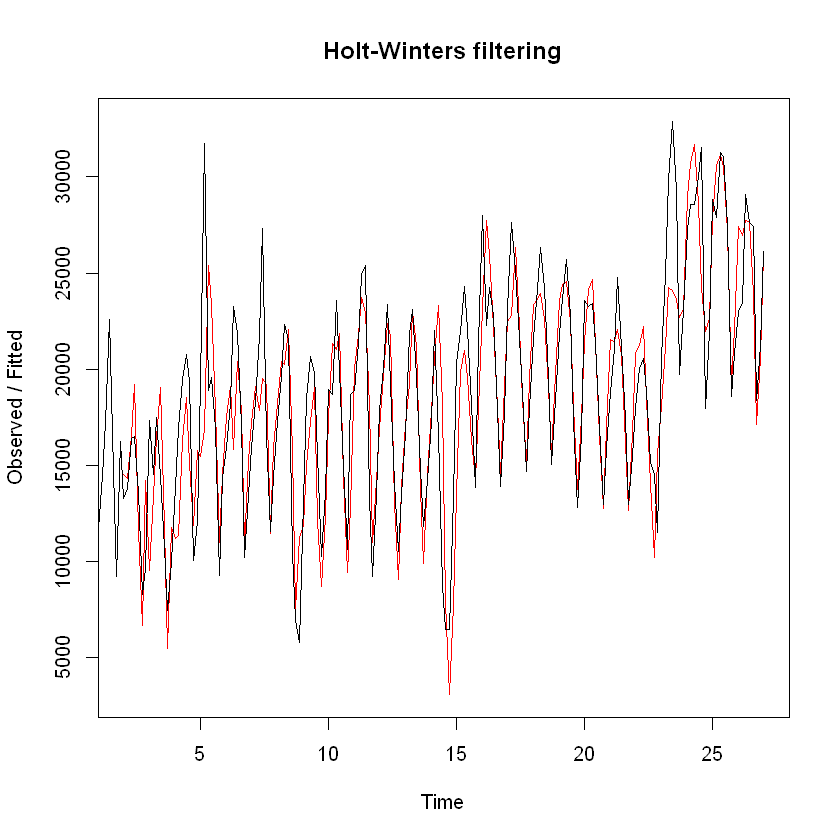

In [26]:
plot(hwBoro)

##### Well, that's good news.

# Manhattan pick-ups forecast for the month of October is: 

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
27.14286       27715.43 23800.79 31630.08 21728.51 33702.36
27.28571       31187.85 26917.09 35458.60 24656.29 37719.41
27.42857       30263.68 25655.05 34872.31 23215.39 37311.98
27.57143       27387.55 22455.41 32319.69 19844.49 34930.60

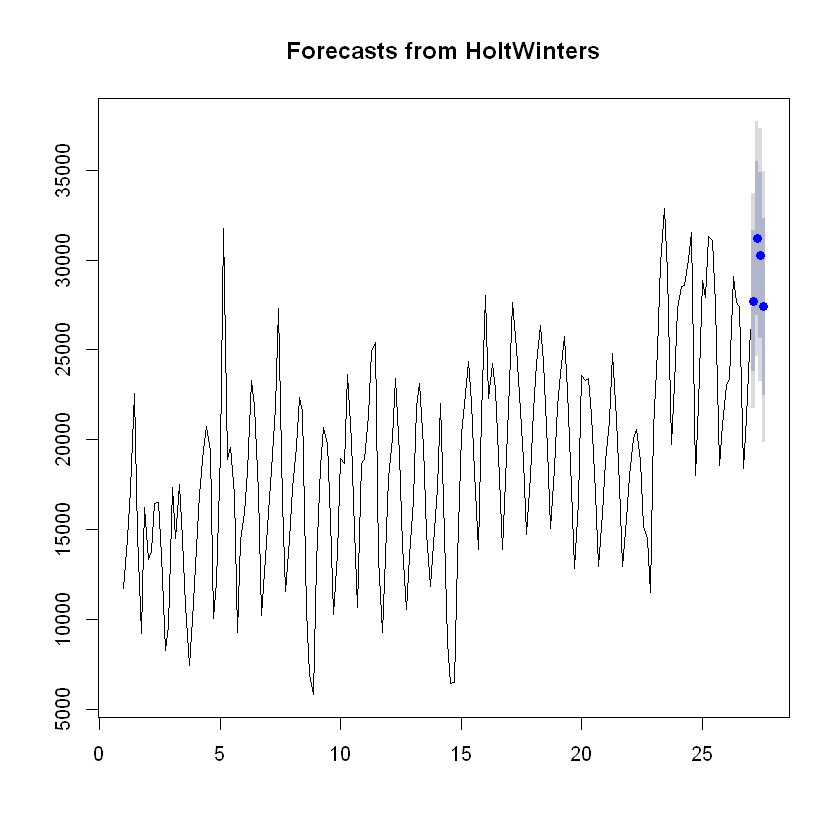

In [27]:
# forecast the next four weeks, get the values, and represent graphically
hwForecast <- forecast(hwBoro, h=4)
plot(hwForecast)
hwForecast

## October forecast: ‭89,318‬
    let's complete a few more checks to ensure this is plausible


	Box-Ljung test

data:  hwForecast$residuals
X-squared = 33.366, df = 20, p-value = 0.03074


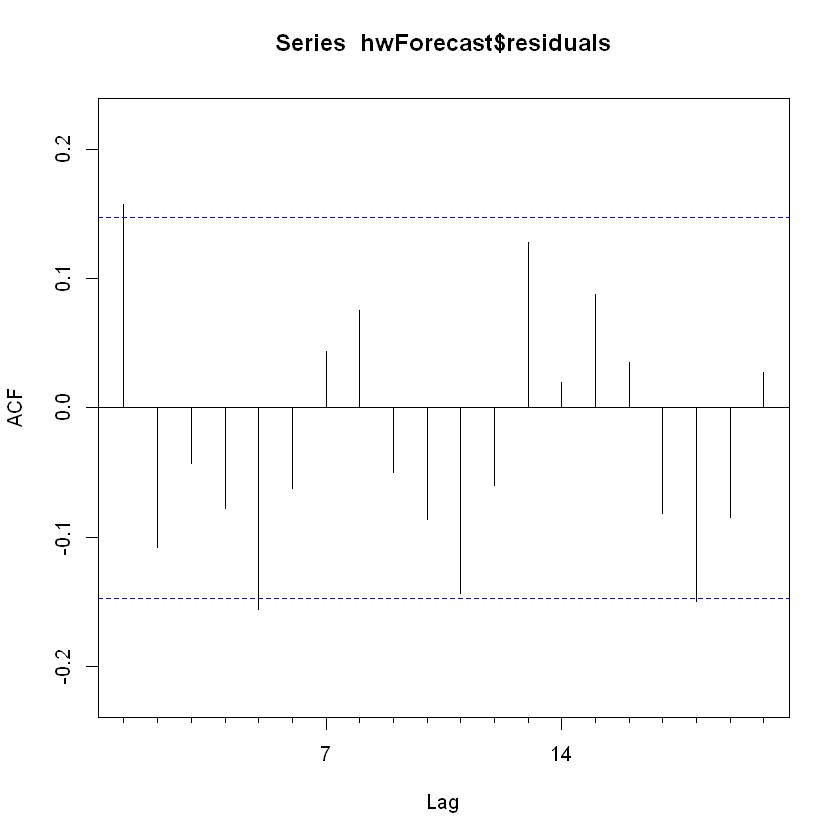

In [28]:
Acf(hwForecast$residuals, lag.max=20)
Box.test(hwForecast$residuals, lag=20, type="Ljung-Box")

p-value and correlogram's auto-correlation values which exceed the significance bounds are both reasonable

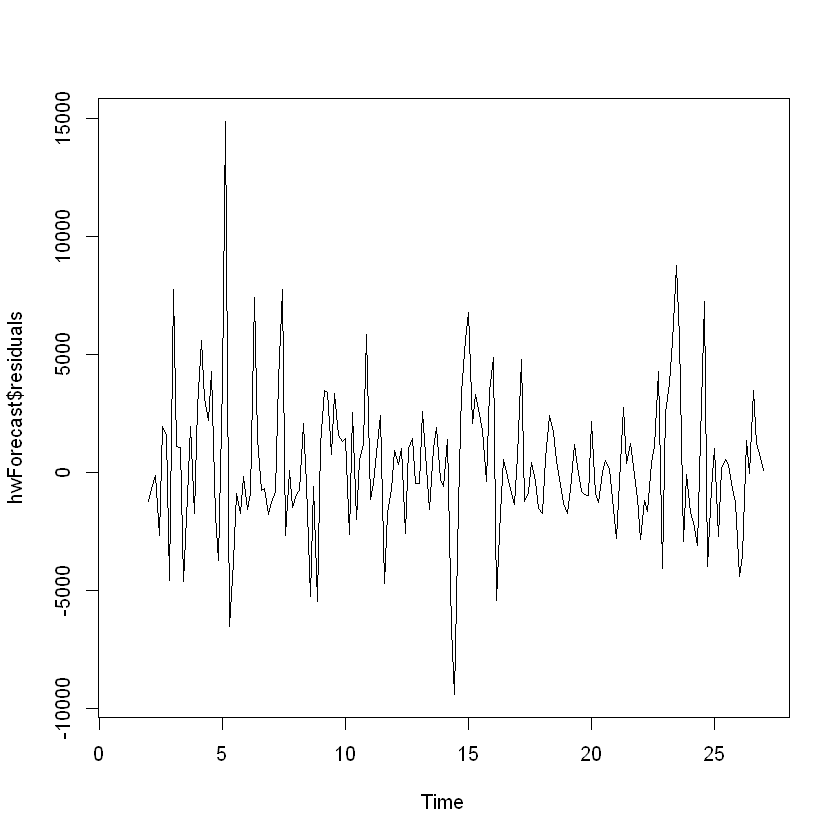

In [29]:
plot(hwForecast$residuals)

Forecast errors have a roughly constant variance over time, this is good.

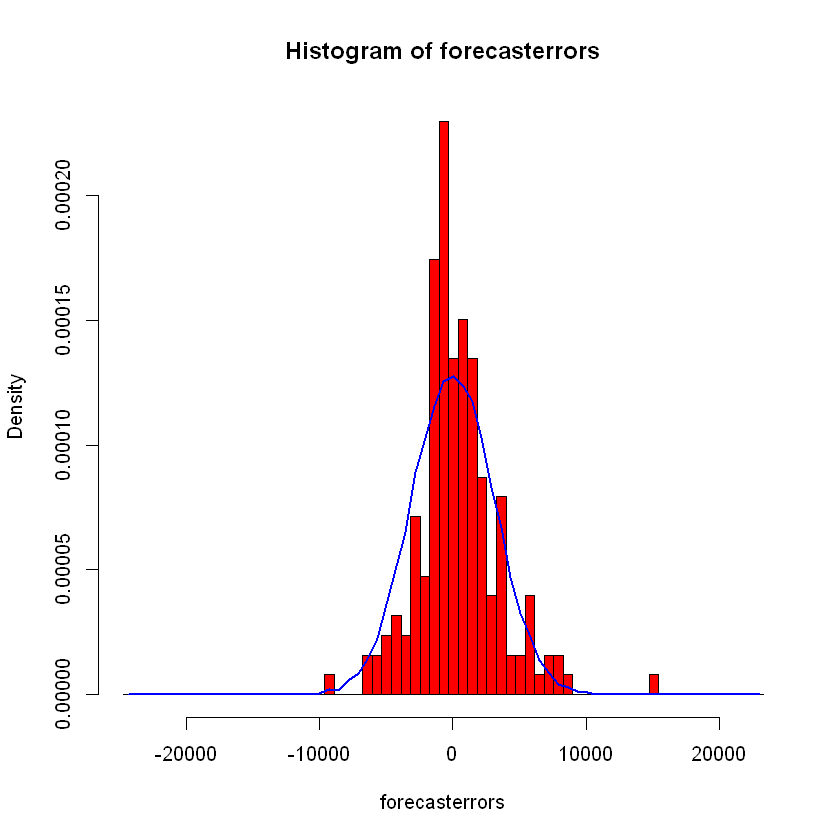

In [30]:
plotForecastErrors(hwForecast$residuals)

Forecast errors are roughly distributed around zero on this plot. Holt-winters makes the grade.

###### Would an ARIMA model be more accurate?

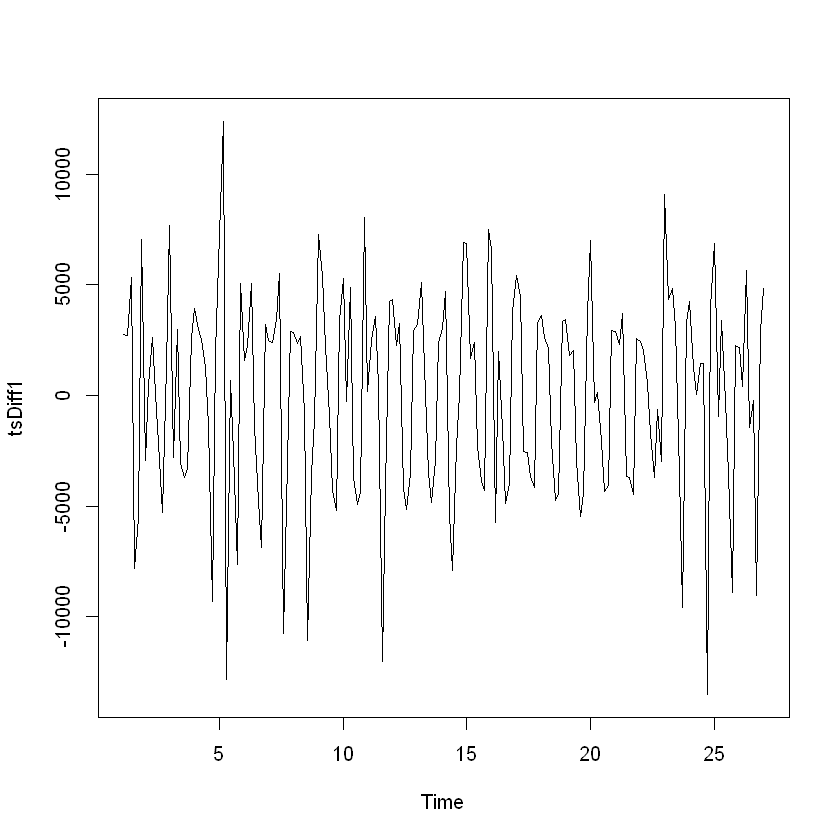

In [31]:
#How many differences to produce a stationary series in terms of mean and variance?
tsDiff1 <- diff(tsBoro,differences=1)
plot.ts(tsDiff1)


Autocorrelations of series 'tsDiff1', by lag

 0.000  0.143  0.286  0.429  0.571  0.714  0.857  1.000  1.143  1.286  1.429 
 1.000  0.145 -0.261 -0.345 -0.359 -0.209  0.246  0.603  0.263 -0.206 -0.370 
 1.571  1.714  1.857  2.000  2.143  2.286  2.429  2.571  2.714  2.857  3.000 
-0.380 -0.189  0.320  0.530  0.243 -0.154 -0.374 -0.371 -0.161  0.268  0.510 
 3.143 
 0.236 

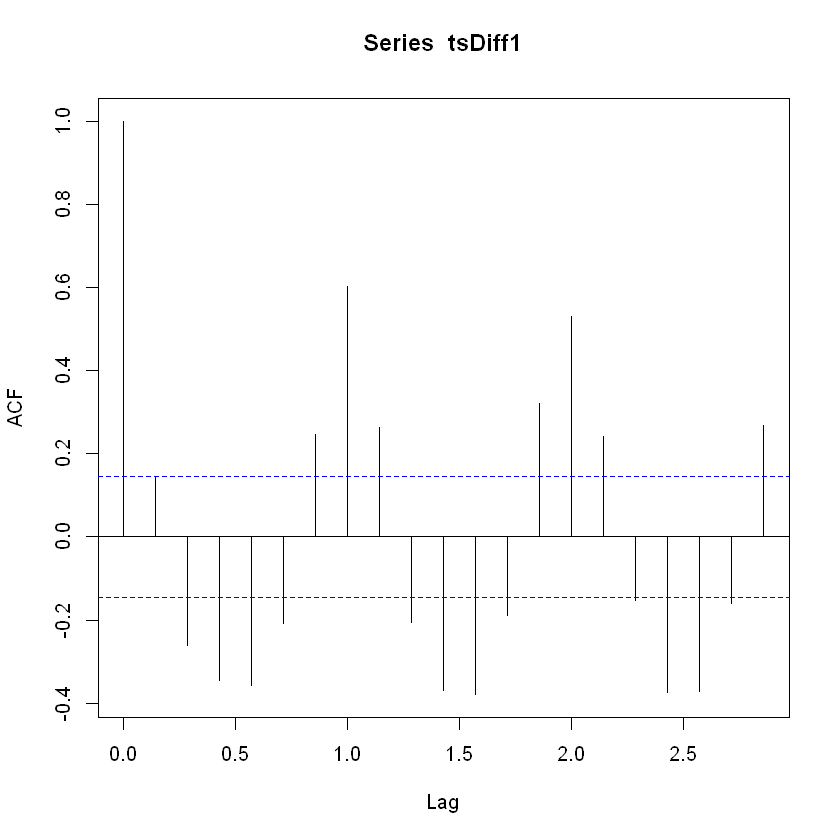

In [32]:
# That's stationary, check the auto-correlations
acf(tsDiff1, lag.max=20)
acf(tsDiff1, lax.max=20, plot=FALSE)


Partial autocorrelations of series 'tsDiff1', by lag

 0.143  0.286  0.429  0.571  0.714  0.857  1.000  1.143  1.286  1.429  1.571 
 0.145 -0.288 -0.283 -0.415 -0.483 -0.260  0.207  0.175  0.017 -0.054 -0.162 
 1.714  1.857  2.000  2.143  2.286  2.429  2.571  2.714  2.857  3.000  3.143 
-0.246 -0.044  0.042  0.037  0.015 -0.032 -0.023 -0.087 -0.121 -0.037 -0.061 

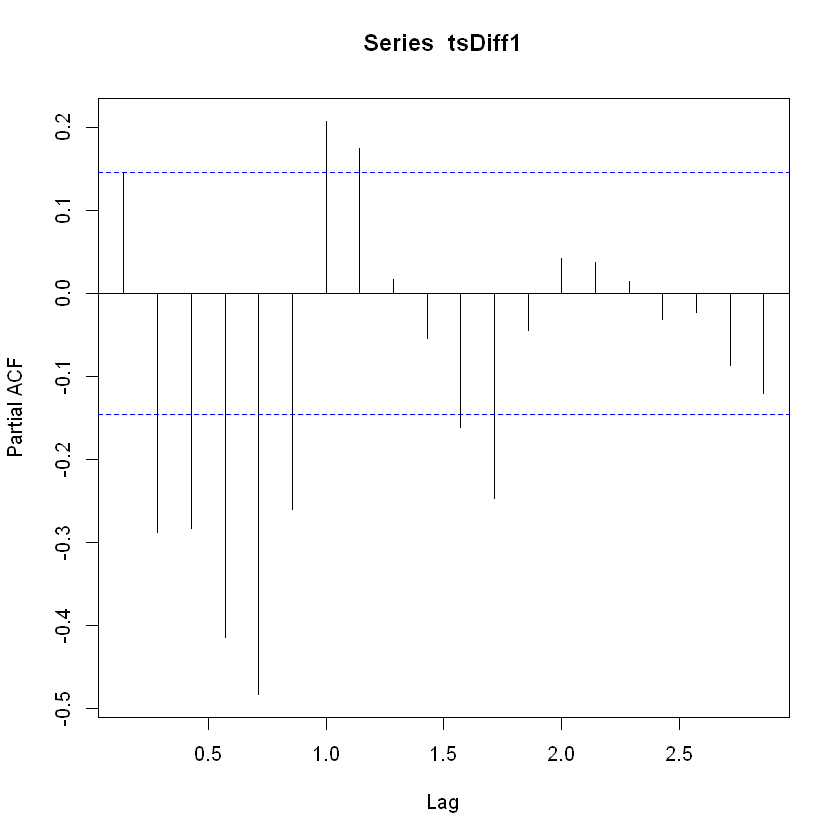

In [33]:
# Too many points (all but one) exceed the significance bounds on this correlogram, 
# check partial autocorrelations just to be sure
pacf(tsDiff1, lag.max=20)
pacf(tsDiff1, lax.max=20, plot=FALSE)

In [ ]:
#similar results, stick with Holt-Winters model